In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
import random
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import keras

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

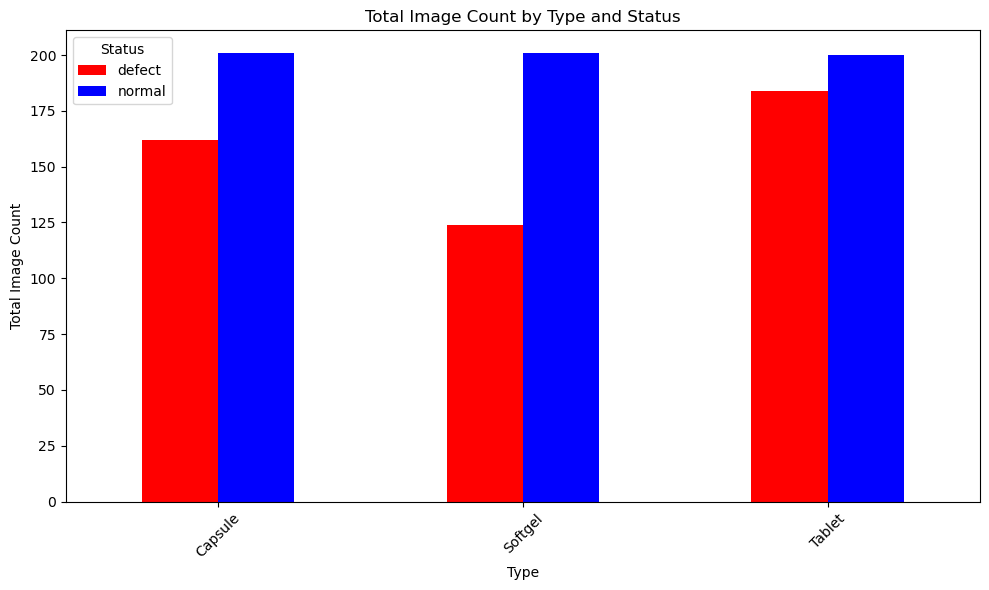

In [3]:
# Define the path to the main folder
main_folder = './dataset'

# Supported image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

# Function to check if a file is an image
def is_image(file):
    return os.path.splitext(file)[1].lower() in image_extensions

# List to hold the data
data = []

# Loop through each folder in the main folder
for subdir, dirs, files in os.walk(main_folder):
    if subdir != main_folder:  # Ensure not to pick from the main folder itself
        image_count = sum(1 for file in files if is_image(file))
        folder_name = os.path.basename(subdir)
        
        # Assuming folder names like 'caplet_normal', split by an underscore
        parts = folder_name.split('_')
        if len(parts) == 2:
            type, status = parts
        else:
            type, status = folder_name, 'Unknown'  # Default status if not specified
        
        # Append the data
        data.append({"Type": type, "Status": status, "Count": image_count})

# Create DataFrame
df = pd.DataFrame(data)

# Filter out entries with zero images if necessary
df = df[df['Count'] > 0].reset_index(drop=True)

# Create a pivot table for plotting
pivot_df = df.pivot_table(index='Type', columns='Status', values='Count', fill_value=0).reset_index()

# Define custom colors for the plot
colors = ['red', 'blue']  # Adjust the number and colors based on actual statuses

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', x='Type', ax=ax, color=colors[:len(pivot_df.columns)-1])
plt.xlabel('Type')
plt.ylabel('Total Image Count')
plt.title('Total Image Count by Type and Status')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

In [4]:
from PIL import Image

Displaying an image from: ./dataset\Capsule_defect


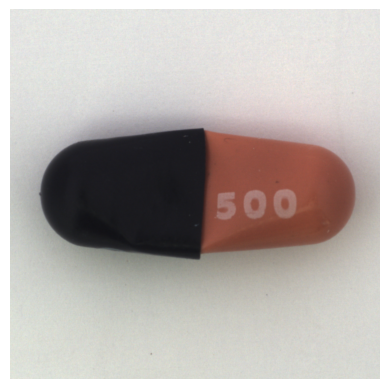

Displaying an image from: ./dataset\Capsule_normal


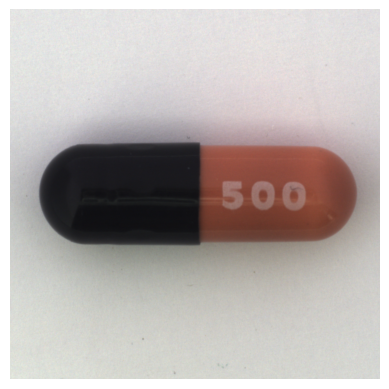

Displaying an image from: ./dataset\Softgel_defect


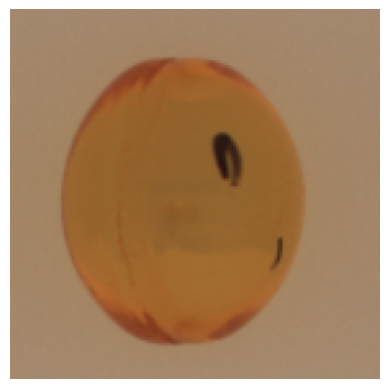

Displaying an image from: ./dataset\Softgel_normal


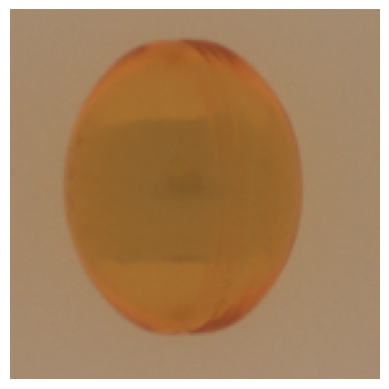

Displaying an image from: ./dataset\Tablet_defect


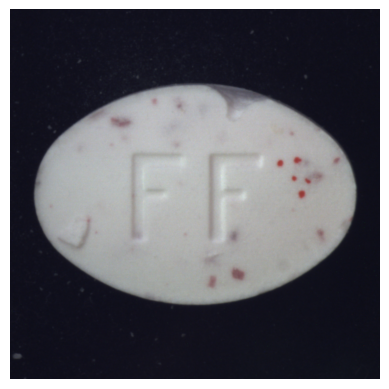

Displaying an image from: ./dataset\Tablet_normal


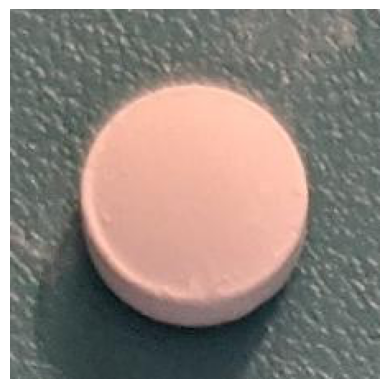

In [5]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for subdir, dirs, files in os.walk(main_folder):
    if subdir != main_folder:  # Ensure not to pick from the main folder itself
        if files:  # Check if there are files in the subfolder
            random_image = random.choice(files)  # Pick a random file
            image_path = os.path.join(subdir, random_image)
            print(f"Displaying an image from: {subdir}")
            display_image(image_path)

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to the main dataset directory
data_dir = './dataset'
train_dir = './data_split/train'
val_dir = './data_split/val'
test_dir = './data_split/test'

# Ensure the train, validation, and test directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size = 0.2, test_size=0.1):

    # Iterate over each class directory in the source directory
    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        if os.path.isdir(class_path):
            # Create class directories in train, val, and test directories
            os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

            # Get all file names in the class directory
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            # Split the data
            train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
            val_files, test_files = train_test_split(temp_files, test_size=test_size / (1 - train_size), random_state=42)

            # Function to copy files
            def copy_files(files, dest_dir):
                for file in files:
                    shutil.copy(os.path.join(class_path, file), os.path.join(dest_dir, class_dir, file))

            # Copy files to their respective directories
            copy_files(train_files, train_dir)
            copy_files(val_files, val_dir)
            copy_files(test_files, test_dir)

# Call the function to split the data
split_data(data_dir, train_dir, val_dir, test_dir)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale =1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

In [6]:
train_generator = datagen.flow_from_directory(
    directory=r"./data_split/train/",  # Path to the main directory where subfolders are stored
    target_size=(255, 255),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42 
)

# Set up validation data generator
valid_generator = datagen.flow_from_directory(
    directory=r"./data_split/val/",  # Use the same directory path as the training data
    target_size=(255, 255),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale =1./255)

test_generator = test_datagen.flow_from_directory(
    directory=r"./data_split/test/",
    target_size=(255, 255),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 747 images belonging to 6 classes.
Found 214 images belonging to 6 classes.
Found 111 images belonging to 6 classes.


In [10]:
class_indices = train_generator.classes

# Count occurrences of each class index
unique, counts = np.unique(class_indices, return_counts=True)
class_counts = dict(zip(unique, counts))

# If you want to print class names along with their counts
class_names = {v: k for k, v in train_generator.class_indices.items()}
class_counts_named = {class_names[k]: v for k, v in class_counts.items()}

print(class_counts_named)

{'Capsule_defect': 113, 'Capsule_normal': 140, 'Softgel_defect': 86, 'Softgel_normal': 140, 'Tablet_defect': 128, 'Tablet_normal': 140}


In [11]:
class_indices = valid_generator.classes


unique, counts = np.unique(class_indices, return_counts=True)
class_counts = dict(zip(unique, counts))


class_names = {v: k for k, v in valid_generator.class_indices.items()}
class_counts_named = {class_names[k]: v for k, v in class_counts.items()}

print(class_counts_named)

{'Capsule_defect': 32, 'Capsule_normal': 40, 'Softgel_defect': 25, 'Softgel_normal': 40, 'Tablet_defect': 37, 'Tablet_normal': 40}


In [12]:
class_indices = test_generator.classes


unique, counts = np.unique(class_indices, return_counts=True)
class_counts = dict(zip(unique, counts))


class_names = {v: k for k, v in test_generator.class_indices.items()}
class_counts_named = {class_names[k]: v for k, v in class_counts.items()}

print(class_counts_named)

{'Capsule_defect': 17, 'Capsule_normal': 21, 'Softgel_defect': 13, 'Softgel_normal': 21, 'Tablet_defect': 19, 'Tablet_normal': 20}


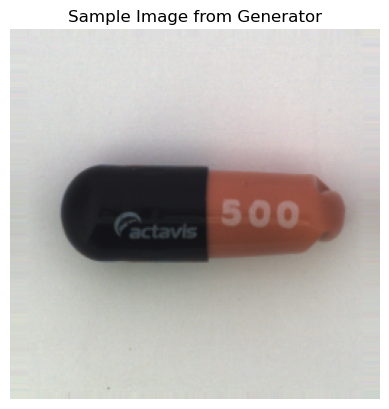

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming 'train_generator' is already created using ImageDataGenerator and flow_from_directory

# Get a batch of images and labels from the generator
images, labels = next(train_generator)

# Select the first image in the batch
image = images[20]

# Convert the image pixels back to the 0-255 range (if rescaling was applied)
image = image * 255.0

# Ensure correct integer data type for display
image = image.astype(np.uint8)

# Display the image
plt.imshow(image)
plt.title("Sample Image from Generator")
plt.axis('off')  # Hide the axis
plt.show()

In [14]:
labels[20]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation = "softmax")]
    #keras.layers.Activation('softmax')]
)

In [16]:
epoch = 50
steps_per_epoch = 10

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator, epochs = epoch, steps_per_epoch = steps_per_epoch,verbose = 1, validation_data=valid_generator)

Epoch 1/50
10/10 [==============================] - 46s 5s/step - loss: 20.4719 - accuracy: 0.2531 - val_loss: 6.9846 - val_accuracy: 0.3645
Epoch 2/50
10/10 [==============================] - 44s 4s/step - loss: 3.6093 - accuracy: 0.4969 - val_loss: 2.6885 - val_accuracy: 0.3925
Epoch 3/50
10/10 [==============================] - 39s 4s/step - loss: 1.9337 - accuracy: 0.5184 - val_loss: 1.5038 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 40s 4s/step - loss: 1.4916 - accuracy: 0.5813 - val_loss: 0.8382 - val_accuracy: 0.6495
Epoch 5/50
10/10 [==============================] - 38s 4s/step - loss: 1.3390 - accuracy: 0.5920 - val_loss: 1.1462 - val_accuracy: 0.5841
Epoch 6/50
10/10 [==============================] - 39s 4s/step - loss: 0.7856 - accuracy: 0.6388 - val_loss: 0.6129 - val_accuracy: 0.6495
Epoch 7/50
10/10 [==============================] - 40s 4s/step - loss: 0.7481 - accuracy: 0.6031 - val_loss: 0.7831 - val_accuracy: 0.6542
Epoch 8/50
10/10 [=

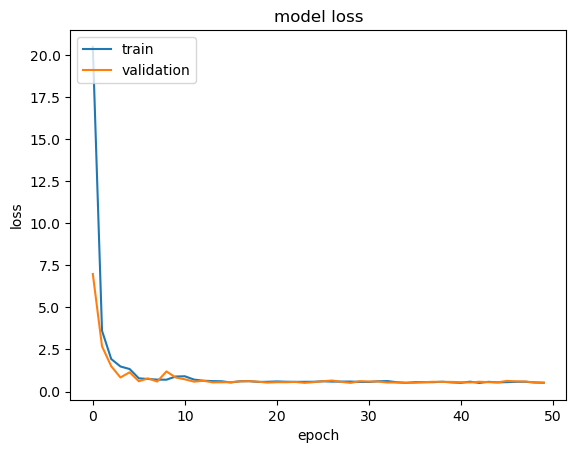

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("initial_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("initial_model.h5")
# print("Saved model to disk")

In [20]:
model.save('initial_model_v2.h5')
# print("Saved model to disk")

In [43]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale =1./255)


test_generator = test_datagen.flow_from_directory(
    directory=r"./data_split/test/",
    target_size=(255, 255),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


score = model.evaluate(test_generator, verbose=0)


print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Found 111 images belonging to 6 classes.
accuracy: 70.27%


In [44]:
score

[0.5558822751045227, 0.7027027010917664]

In [45]:
y_pred_probabilities = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred_probabilities, axis=1)

C:\Users\vinezhapanca\AppData\Local\Temp\ipykernel_12024\3618652926.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_probabilities = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)


4/4 [==============================] - 3s 639ms/step


In [46]:
y_true = test_generator.classes

In [47]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [48]:
conf_matrix

array([[11,  6,  0,  0,  0,  0],
       [ 9, 12,  0,  0,  0,  0],
       [ 0,  0,  3, 10,  0,  0],
       [ 0,  0,  0, 21,  0,  0],
       [ 0,  0,  0,  0, 18,  1],
       [ 0,  0,  0,  0,  7, 13]], dtype=int64)

In [49]:
Y_pred = model.predict_generator(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

C:\Users\vinezhapanca\AppData\Local\Temp\ipykernel_12024\2665107455.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, steps=len(test_generator))


Confusion Matrix
[[11  6  0  0  0  0]
 [ 9 12  0  0  0  0]
 [ 0  0  3 10  0  0]
 [ 0  0  0 21  0  0]
 [ 0  0  0  0 18  1]
 [ 0  0  0  0  7 13]]
Classification Report


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_generator.classes, y_pred, target_names=['Caps_Def', 'Caps_Normal', 'Softgel_Def', 'Softgel_Normal', 'Tablet_Def', 'Tablet_Normal']))

                precision    recall  f1-score   support

      Caps_Def       0.55      0.65      0.59        17
   Caps_Normal       0.67      0.57      0.62        21
   Softgel_Def       1.00      0.23      0.38        13
Softgel_Normal       0.68      1.00      0.81        21
    Tablet_Def       0.72      0.95      0.82        19
 Tablet_Normal       0.93      0.65      0.76        20

      accuracy                           0.70       111
     macro avg       0.76      0.67      0.66       111
  weighted avg       0.75      0.70      0.68       111



In [67]:
callback = keras.callbacks.EarlyStopping(
    patience=5
)

In [68]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation = "softmax")]
    #keras.layers.Activation('softmax')]
)
model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_with_callback = model_2.fit(train_generator,epochs = 50,verbose = 1,callbacks=[callback], validation_data=valid_generator)
    

Epoch 1/50
24/24 [==============================] - 84s 3s/step - loss: 12.9901 - accuracy: 0.4123 - val_loss: 2.0705 - val_accuracy: 0.5514
Epoch 2/50
24/24 [==============================] - 82s 3s/step - loss: 1.5501 - accuracy: 0.5743 - val_loss: 1.0484 - val_accuracy: 0.6028
Epoch 3/50
24/24 [==============================] - 82s 3s/step - loss: 0.8069 - accuracy: 0.6345 - val_loss: 1.0163 - val_accuracy: 0.5935
Epoch 4/50
24/24 [==============================] - 83s 3s/step - loss: 0.8525 - accuracy: 0.6212 - val_loss: 0.6552 - val_accuracy: 0.6963
Epoch 5/50
24/24 [==============================] - 85s 4s/step - loss: 0.6169 - accuracy: 0.6720 - val_loss: 0.6364 - val_accuracy: 0.6028
Epoch 6/50
24/24 [==============================] - 86s 4s/step - loss: 0.6198 - accuracy: 0.6493 - val_loss: 0.6169 - val_accuracy: 0.6262
Epoch 7/50
24/24 [==============================] - 90s 4s/step - loss: 0.6399 - accuracy: 0.6426 - val_loss: 0.6450 - val_accuracy: 0.6121
Epoch 8/50
24/24 [=

In [70]:
score_with_callback = model_2.evaluate(test_generator, verbose=0)
print("accuracy of the model with early stopping : " + str(score_with_callback[1]))
print("%s: %.2f%%" % ("accuracy of the model with early stopping : ", score_with_callback[1]*100))

accuracy of the model with early stopping : 0.684684693813324
accuracy of the model with early stopping : : 68.47%


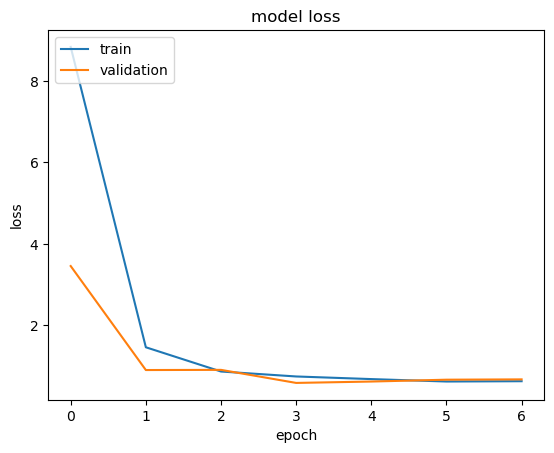

In [25]:
plt.plot(history_with_callback.history['loss'])
plt.plot(history_with_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
model_2.save('model_with_early_stopping_v2.h5')
print("Saved model to disk")

Saved model to disk


In [51]:
y_pred_probabilities = model_2.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred_probabilities, axis=1)

C:\Users\vinezhapanca\AppData\Local\Temp\ipykernel_12024\2231180581.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_probabilities = model_2.predict_generator(test_generator, steps=len(test_generator), verbose=1)


4/4 [==============================] - 3s 640ms/step


In [52]:
y_true = test_generator.classes

In [53]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [54]:
conf_matrix

array([[ 0, 17,  0,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0],
       [ 0,  0,  8,  5,  0,  0],
       [ 0,  0,  7, 14,  0,  0],
       [ 0,  0,  0,  0,  8, 11],
       [ 0,  0,  0,  0,  1, 19]], dtype=int64)

In [57]:
Y_pred = model_2.predict_generator(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

C:\Users\vinezhapanca\AppData\Local\Temp\ipykernel_12024\4042384008.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_2.predict_generator(test_generator, steps=len(test_generator))


Confusion Matrix
[[ 0 17  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0  8  5  0  0]
 [ 0  0  7 14  0  0]
 [ 0  0  0  0  8 11]
 [ 0  0  0  0  1 19]]
Classification Report


In [58]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_generator.classes, y_pred, target_names=['Caps_Def', 'Caps_Normal', 'Softgel_Def', 'Softgel_Normal', 'Tablet_Def', 'Tablet_Normal']))

                precision    recall  f1-score   support

      Caps_Def       0.00      0.00      0.00        17
   Caps_Normal       0.55      1.00      0.71        21
   Softgel_Def       0.53      0.62      0.57        13
Softgel_Normal       0.74      0.67      0.70        21
    Tablet_Def       0.89      0.42      0.57        19
 Tablet_Normal       0.63      0.95      0.76        20

      accuracy                           0.63       111
     macro avg       0.56      0.61      0.55       111
  weighted avg       0.57      0.63      0.57       111



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
